**Anharmonic oscillator**

x^3 in the propagator

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math
from numpy.random import uniform
from numpy import *

**parameters**

In [2]:
a=1/2
N=20
N_cf=10000
N_cor=20
N_stat=100
epsilon=1.4
m=1

**arrays allocation**

In [3]:
x = np.zeros((N,),np.float64)
G = np.zeros((N_cf,N),np.float64)
G_avgs=np.zeros((N,N_stat),np.float64)
G_sim=np.zeros((N_stat,N_cf,N),np.float64)

**Metropolis sweep**

In [4]:
def update(x,m,a,epsilon):
    accept=0
    
    for i in range(len(x)):
        x_old=x[i]
        S_old=S(i,x,m,a)
        
        noise=uniform(-epsilon,epsilon)
        x[i]+=noise
        S_new=S(i,x,m,a)
        dS= S_new-S_old
        
        if dS > 0 and exp(-dS)<uniform(0,1):
            x[i]=x_old
        else:
            accept += 1
            
    return accept/len(x)

dS concerning only a certain x[i]

In [5]:
def S(i,x,m,a):
    i_p = (i+1)%len(x)    # next site
    i_m = (i-1)%len(x)    # previous site
    return a*((x[i])**4)/2 + x[i]*(x[i]-x[i_p]-x[i_m])*(m/a)

In [6]:
def compute_G(x,n):
    g = 0
    for i in range(N):
        g = g + (x[i]**3)*(x[(i+n)%N]**3)
    return g/N

In [7]:
def MCaverage(x,G,N_corr,N_cf):
    
    accepted=0
    for j in range(10*N_corr):
        update(x,m,a,epsilon)
    accepted=accepted/(10*N_corr)
    
    for alpha in range(N_cf):
        for i in range(N_corr):
            accepted+=update(x,m,a,epsilon)
        for n in range(N):
            G[alpha][n] = compute_G(x,n)
    accepted=accepted/(N_cf*N_corr)
    #in the end we have a matrix with N_cf rows and len(x) columns
    #we have to compute averages summing over alphas
    G_sim[0]=G
    for k in range(1,N_stat):
        G_sim[k]=bootstrap(G)
    #G_avgs=[]
    for k in range(N_stat):
        for n in range(N):
            avg=0
            for alpha in range(N_cf):
                G_avgs[n][k]+=G_sim[k][alpha][n]
            G_avgs[n][k]=G_avgs[n][k]/N_cf
    #print(f"averages: {G_avgs}")
    return G_avgs,accepted

In [8]:
def bootstrap(G): 
    N_cf = len(G)
    G_bootstrap = [] # new ensemble
    for i in range(0,N_cf):
        alpha = int(uniform(0,N_cf))
        G_bootstrap.append(G[alpha]) 
    return G_bootstrap

In [9]:
# choose random config # keep G[alpha]
def bin(G,binsize): 
    G_binned = []
    for i in range(0,len(G),binsize): 
        G_avg = 0
        for j in range(0,binsize): 
            G_avg = G_avg + G[i+j]
        G_binned.append(G_avg/binsize)
    return G_binned




In [10]:
#returns an array of averages of length N [Gavg0, ..., Gavg(N-1)]
def DeltaE(G_avgs):
    for k in range(N_stat):
        for n in range(N-1):
            dE[n][k] =np.log(np.abs(G_avgs[n][k]/G_avgs[n+1][k]))/a
            #np.log(np.divide(G_avgs[:-1],G_avgs[1:]))
            t[n]=n*a
            #exact[n]=1
    return dE

In [11]:
def stat_analysis(dE):
    for n in range(N-1):
        for k in range(N_stat):
            mean_dE[n]+=dE[n][k]
            mean_dE_square[n]+=(dE[n][k])**2
        mean_dE[n]=mean_dE[n]/N_stat
        mean_dE_square[n]=mean_dE_square[n]/N_stat
        error_dE[n]=((mean_dE_square[n]-(mean_dE[n])**2))**(1/2)
    return mean_dE,error_dE
   

In [12]:
dE=np.zeros((N-1,N_stat),np.float64)
DE=np.zeros((N-1,N_stat),np.float64)
mean_dE=np.zeros(N-1,np.float64)
mean_DE=np.zeros(N-1,np.float64)
mean_dE_square=np.zeros(N-1,np.float64)
error_dE=np.zeros(N-1,np.float64)
error_DE=np.zeros(N-1,np.float64)
t=np.zeros(N-1,np.float64)

In [13]:
MC_avg=0
accept_rate=0

MC_avg,accept_rate=MCaverage(x,G,N_cor,N_cf)
DE=DeltaE(MC_avg)
mean_DE,error_DE=stat_analysis(DE)
print("acceptance rate: "+str(accept_rate))

acceptance rate: 0.48439124999998273


**plotting**

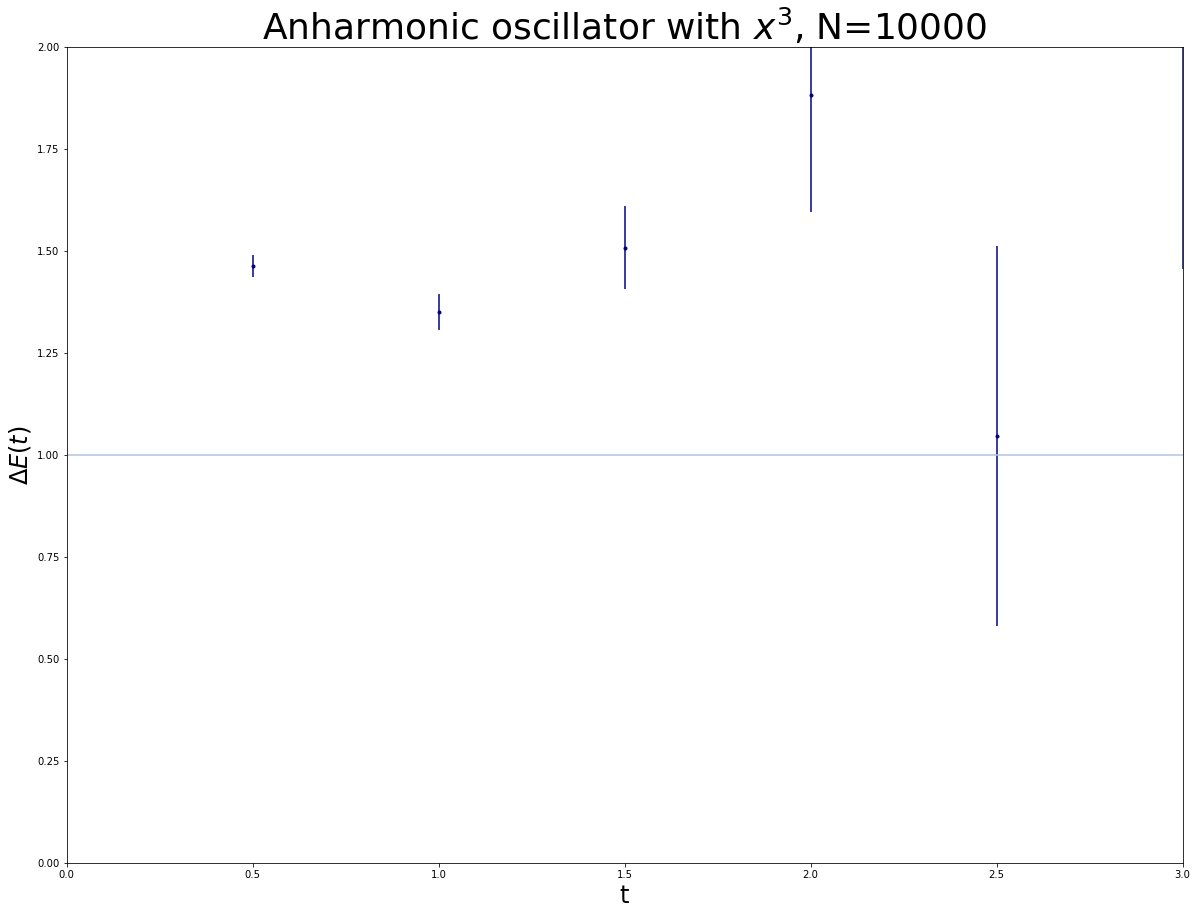

In [15]:
plt.figure(figsize=(20,15)) # 10 is width, 10 is height
plt.title('Anharmonic oscillator with $x^3$, N='+str(N_cf),fontsize=36)
plt.errorbar(t,mean_DE,yerr=error_DE,fmt='.',color='navy',label='numeric')
plt.xlabel(r"t",fontsize=24)
plt.ylabel(r"$\Delta E(t)$",fontsize=24)
plt.xlim(0, 3)
plt.ylim(0,2)
plt.axhline(y=1, color='lightsteelblue', linestyle='-')
#plt.plot(xaxis,yaxis,'o', markersize= 4)

plt.show()